In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.edgecolor"] = "w"
mpl.rcParams['figure.facecolor'] = "w"
mpl.rcParams["savefig.dpi"] = 300

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:

Process:

$$
dY_t^1  = Y_t^2 dt
$$

$$
dY_t^2 =   - \lambda Y_t^2 dt + \lambda \theta \mathcal{E} dt
$$


HJB:

$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\omega_\ell } & - \delta \phi(y_1, y_2) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_{\ell}^L 
\omega_\ell  \theta_\ell \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} \left(\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\} \right) y_2 \\
& + \xi_a \sum_{\ell}^L \omega_\ell (\log \omega_\ell - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
np.log(2)/6

0.11552453009332421

In [3]:
# parameters
δ = 0.01
η = 0.032
ξa = 0.01
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.linspace(0., 1./3, 20)
# y grid
# λ = np.log(2)/6
λ = 0.116

In [4]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)
y1_grid_cap = np.arange(0., 2. + y1_step, y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [ ]:
tol = 1e-7
ϵ = 1.
max_iter = 5_000
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

solu=dict()
for i in range(len(γ3_list)):
    π_p = np.zeros(len(γ3_list))
    π_p[i] = 1
    dΛ1 = γ1 + γ2*y1_mat + π_p@γ3_list*(y1_mat - ȳ)*(y1_mat >ȳ)
# ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
    #     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
    #     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*0.05 + ems_old*0.95
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
#         print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0) 
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
#         print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    result = dict(v0=v0, ems=ems, πa=πa)
    solu[π_p@γ3_list] = result

In [7]:
ϕ_list = np.array([solu[γ3]["v0"] for γ3 in γ3_list])

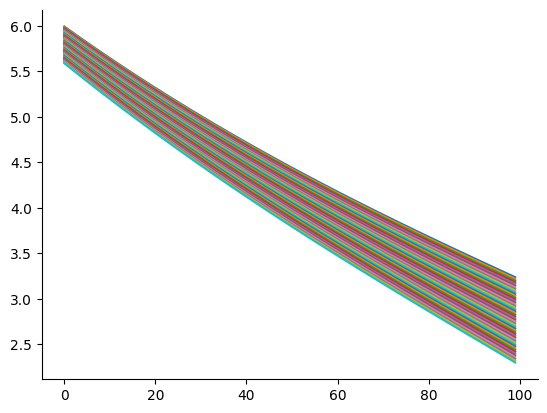

In [8]:
plt.plot(ϕ_list[0])
plt.show()

In [9]:
ems_list = np.array([solu[γ3]["ems"] for γ3 in γ3_list])
np.save("ems_2state", ems_list)

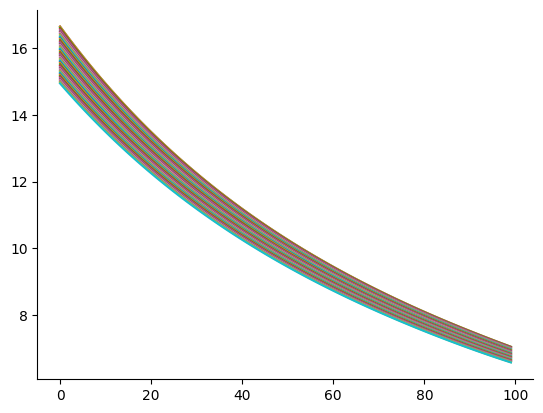

In [10]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [11]:
y1_grid_cap = np.arange(0., 2.1 + y1_step, y1_step)
loc_2 = np.abs(y1_grid - 2.).argmin()
ξp = 1
ϵ = 1.
max_iter = 5000
dmg_weight = np.ones(len(γ3_list)) / len(γ3_list)
ϕ_weight = np.average(np.exp(-1 / ξp * ϕ_list), axis=0, weights=dmg_weight)

ϕ_equiv = -ξp * np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing='ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πd_o = np.ones((len(γ3_list), num_y1, num_y2)) / len(γ3_list)
πa_o = np.ones((len(θ_list), num_y1, num_y2)) / len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2 * y1_mat_cap

r1 = 1.5
r2 = 2.5
y_lower = 1.5
Intensity = r1 * (np.exp(r2 / 2 * (y1_mat_cap - y_lower)**2) -
                  1) * (y1_mat_cap >= y_lower)

# initiate v and control
tol = 1e-6
ems = η
ems_old = ems
lhs_error = 1
episode = 0
v0 = ϕ_equiv[:num_y1]
v_m = np.zeros(πd_o.shape)
for i in range(len(γ3_list)):
    v_m[i] = ϕ_list[i][loc_2]

In [12]:
while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0, 0, 1, hy1)
    #     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
    v0_dy2 = derivatives_2d(v0, 1, 1, hy2)
    #         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
    #     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
    # updating controls
    weight = np.array([-1 / ξa * v0_dy2 * λ * ems_old * θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o * np.exp(weight)
    πa[πa < 1e-15] = 1e-15
    πa = πa / np.sum(πa, axis=0)
    ems_new = -η / (v0_dy2 * λ * np.sum(θ_mat * πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new * 0.05 + ems_old * 0.95
    #     print(np.min(ems))
    g_m = np.exp(1 / ξp * (v0 - v_m))
    # HJB coefficient
    A = -δ * np.ones(y1_mat_cap.shape) - Intensity * np.sum(πd_o * g_m, axis=0)
    B_y1 = y2_mat_cap
    B_y2 = λ * (-y2_mat_cap + ems * np.sum(θ_mat * πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η * np.log(ems) + (η - 1) / δ * dΛ1 * y2_mat_cap + ξa * np.sum(
        πa * (np.log(πa) - np.log(πa_o)), axis=0) + Intensity * np.sum(
            πd_o * g_m * v_m, axis=0) + ξp * Intensity * np.sum(
                πd_o * (1 - g_m + g_m * np.log(g_m)), axis=0)
    phi_mat = false_transient_one_iteration_python(
        A,
        B_y1,
        B_y2,
        C_yy1,
        C_yy2,
        D,
        v0,
        ϵ,
        hy1,
        hy2,
        bc=(np.zeros(num_y2), ϕ_equiv[num_y1 - 1], np.zeros(num_y1),
            np.zeros(num_y1)),
        impose_bc=(False, False, False, False))
#     phi_mat = PDESolver_2d(stateSpace,
#                            A,
#                            B_y1,
#                            B_y2,
#                            C_yy1,
#                            C_yy2,
#                            D,
#                            v0,
#                            ϵ,
#                            solverType='False Transient')
    rhs = A * phi_mat + B_y1 * v0_dy1 + B_y2 * v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat - v0_old) / ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

Episode: 1	 lhs error: 0.972418917243	 rhs error: 0.729428864151
Episode: 2	 lhs error: 0.730740403533	 rhs error: 0.595407202377
Episode: 3	 lhs error: 0.359597708392	 rhs error: 0.374326956599
Episode: 4	 lhs error: 0.207028889179	 rhs error: 0.304124275050
Episode: 5	 lhs error: 0.169786106394	 rhs error: 0.253756393481
Episode: 6	 lhs error: 0.143157314163	 rhs error: 0.215145259251
Episode: 7	 lhs error: 0.121235825661	 rhs error: 0.181420263457
Episode: 8	 lhs error: 0.105632646230	 rhs error: 0.152907194030
Episode: 9	 lhs error: 0.092368466925	 rhs error: 0.129209947553
Episode: 10	 lhs error: 0.081758730343	 rhs error: 0.109697777290
Episode: 11	 lhs error: 0.072940760791	 rhs error: 0.093715241635
Episode: 12	 lhs error: 0.065640997284	 rhs error: 0.080929150488
Episode: 13	 lhs error: 0.059204910985	 rhs error: 0.073305130042
Episode: 14	 lhs error: 0.054123363470	 rhs error: 0.067305485466
Episode: 15	 lhs error: 0.049169375594	 rhs error: 0.062384501344
Episode: 16	 lhs er

Episode: 125	 lhs error: 0.005177990287	 rhs error: 0.044311011605
Episode: 126	 lhs error: 0.005114049790	 rhs error: 0.044310996284
Episode: 127	 lhs error: 0.005046181976	 rhs error: 0.044310980745
Episode: 128	 lhs error: 0.004983838438	 rhs error: 0.044310968346
Episode: 129	 lhs error: 0.004923025066	 rhs error: 0.044310954541
Episode: 130	 lhs error: 0.004858475187	 rhs error: 0.044310944507
Episode: 131	 lhs error: 0.004798851011	 rhs error: 0.044310931836
Episode: 132	 lhs error: 0.004740606670	 rhs error: 0.044310920420
Episode: 133	 lhs error: 0.004678802219	 rhs error: 0.044310909802
Episode: 134	 lhs error: 0.004622395512	 rhs error: 0.044310901179
Episode: 135	 lhs error: 0.004566246484	 rhs error: 0.044310891854
Episode: 136	 lhs error: 0.004506701504	 rhs error: 0.044310884593
Episode: 137	 lhs error: 0.004453835121	 rhs error: 0.044310875234
Episode: 138	 lhs error: 0.004399380276	 rhs error: 0.044310867102
Episode: 139	 lhs error: 0.004342528023	 rhs error: 0.04431086

Episode: 249	 lhs error: 0.000009275038	 rhs error: 0.044310649489
Episode: 250	 lhs error: 0.000009079213	 rhs error: 0.044310647867
Episode: 251	 lhs error: 0.000008895453	 rhs error: 0.044310646514
Episode: 252	 lhs error: 0.000008718926	 rhs error: 0.044310646309
Episode: 253	 lhs error: 0.000008500043	 rhs error: 0.044310643852
Episode: 254	 lhs error: 0.000008246898	 rhs error: 0.044310643230
Episode: 255	 lhs error: 0.000007993424	 rhs error: 0.044310642949
Episode: 256	 lhs error: 0.000007850292	 rhs error: 0.044310641762
Episode: 257	 lhs error: 0.000007666361	 rhs error: 0.044310640050
Episode: 258	 lhs error: 0.000007558053	 rhs error: 0.044310639473
Episode: 259	 lhs error: 0.000007404080	 rhs error: 0.044310639620
Episode: 260	 lhs error: 0.000007265610	 rhs error: 0.044310638029
Episode: 261	 lhs error: 0.000007140884	 rhs error: 0.044310636955
Episode: 262	 lhs error: 0.000006976986	 rhs error: 0.044310635750
Episode: 263	 lhs error: 0.000006781357	 rhs error: 0.04431063

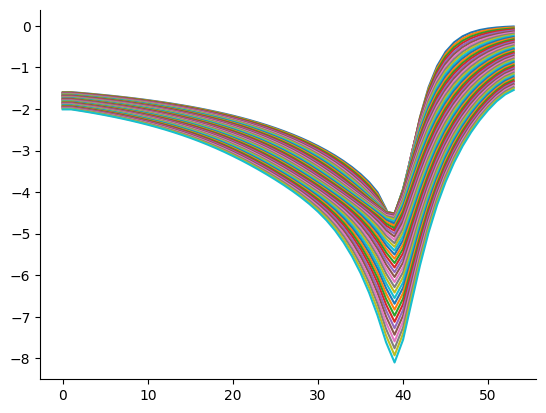

In [13]:
plt.plot(v0_dy1)
plt.show()

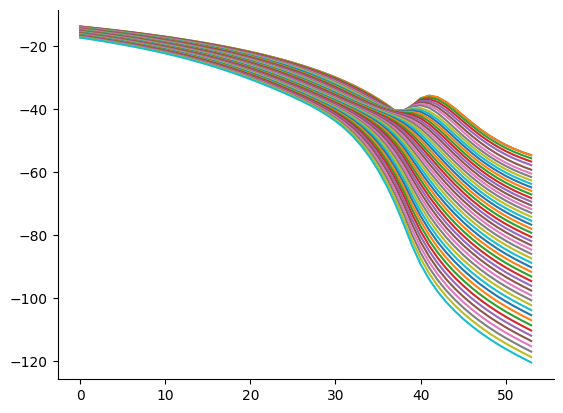

In [14]:
plt.plot(v0_dy2)
plt.show()

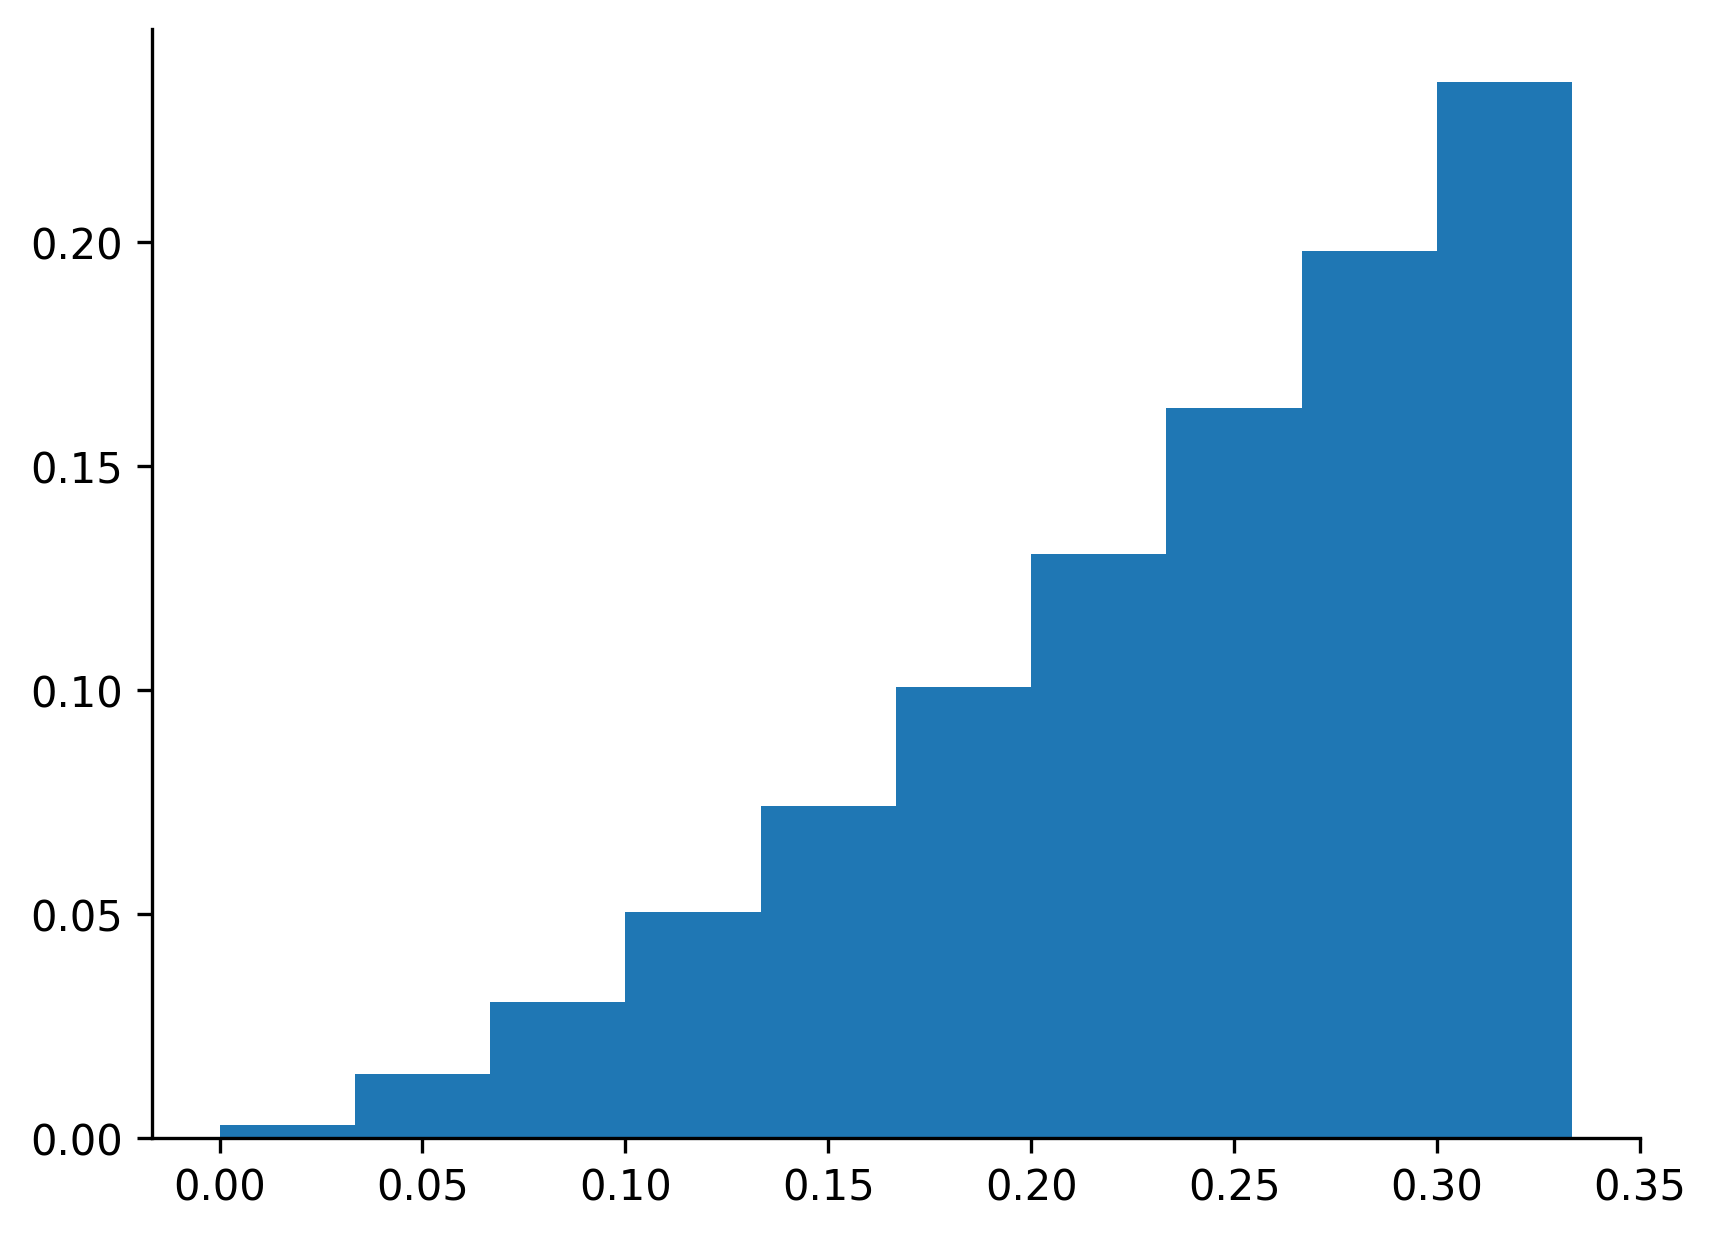

In [72]:
g_i = g_m[:, -1, 2]
plt.hist(γ3_list, weights= g_i/ np.sum(g_i, axis=0))
plt.show()

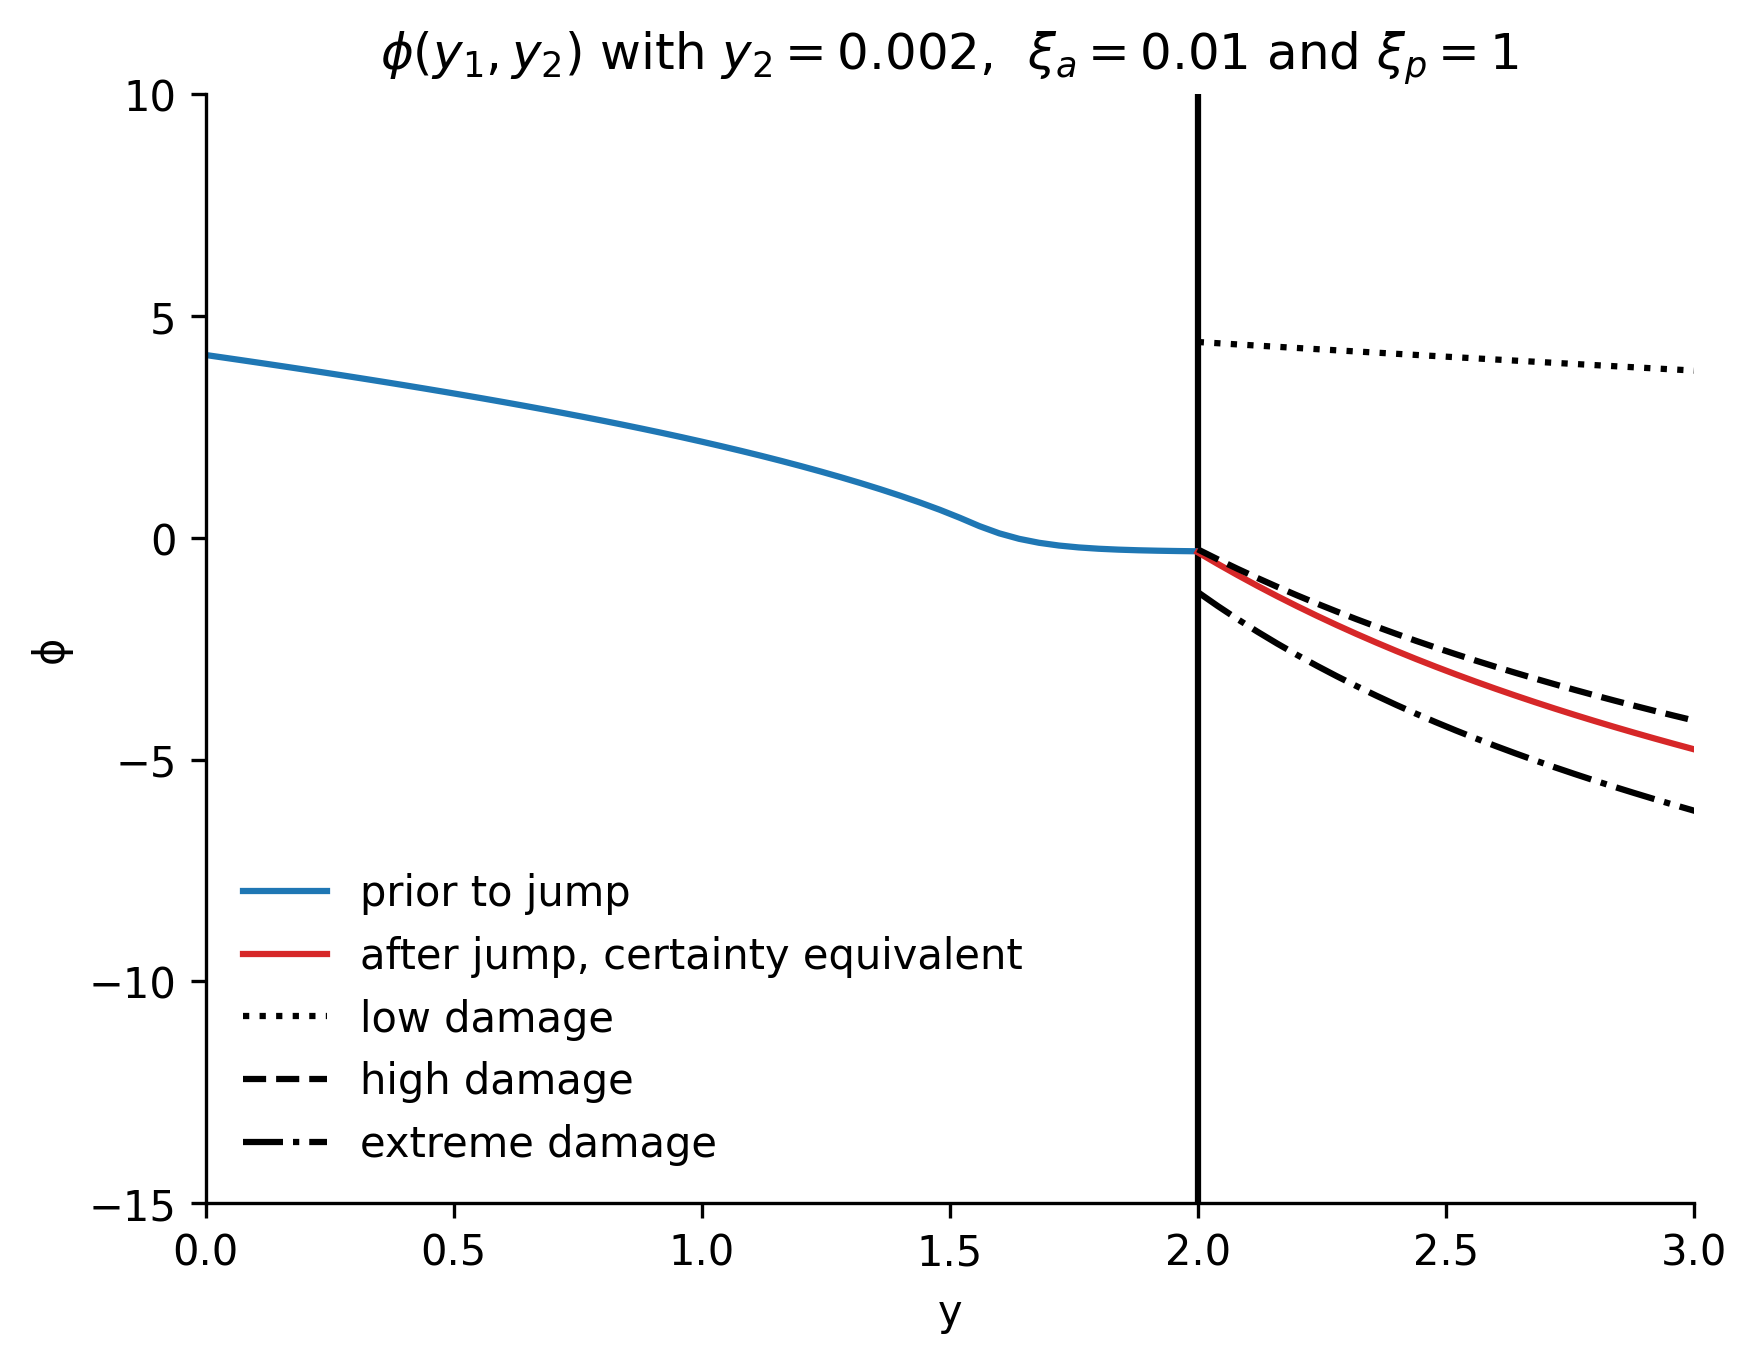

In [73]:
#
plt.plot(y1_grid[:loc_2 + 1],
         phi_mat[:loc_2 + 1, 2],
         color="tab:blue",
         label="prior to jump")
plt.plot(y1_grid[loc_2:],
         ϕ_equiv[loc_2:][:, 2],
         color="tab:red",
         label="after jump, certainty equivalent")
plt.plot(y1_grid[loc_2:],
         ϕ_list[0][loc_2:, 2],
         color="black",
         linestyle=":",
         label="low damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[10][loc_2:, 2],
         color="black",
         linestyle="--",
         label="high damage")
plt.plot(y1_grid[loc_2:],
         ϕ_list[-1][loc_2:, 2],
         color="black",
         linestyle="-.",
         label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 0.01$ and $ξ_p = 1$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15, 10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

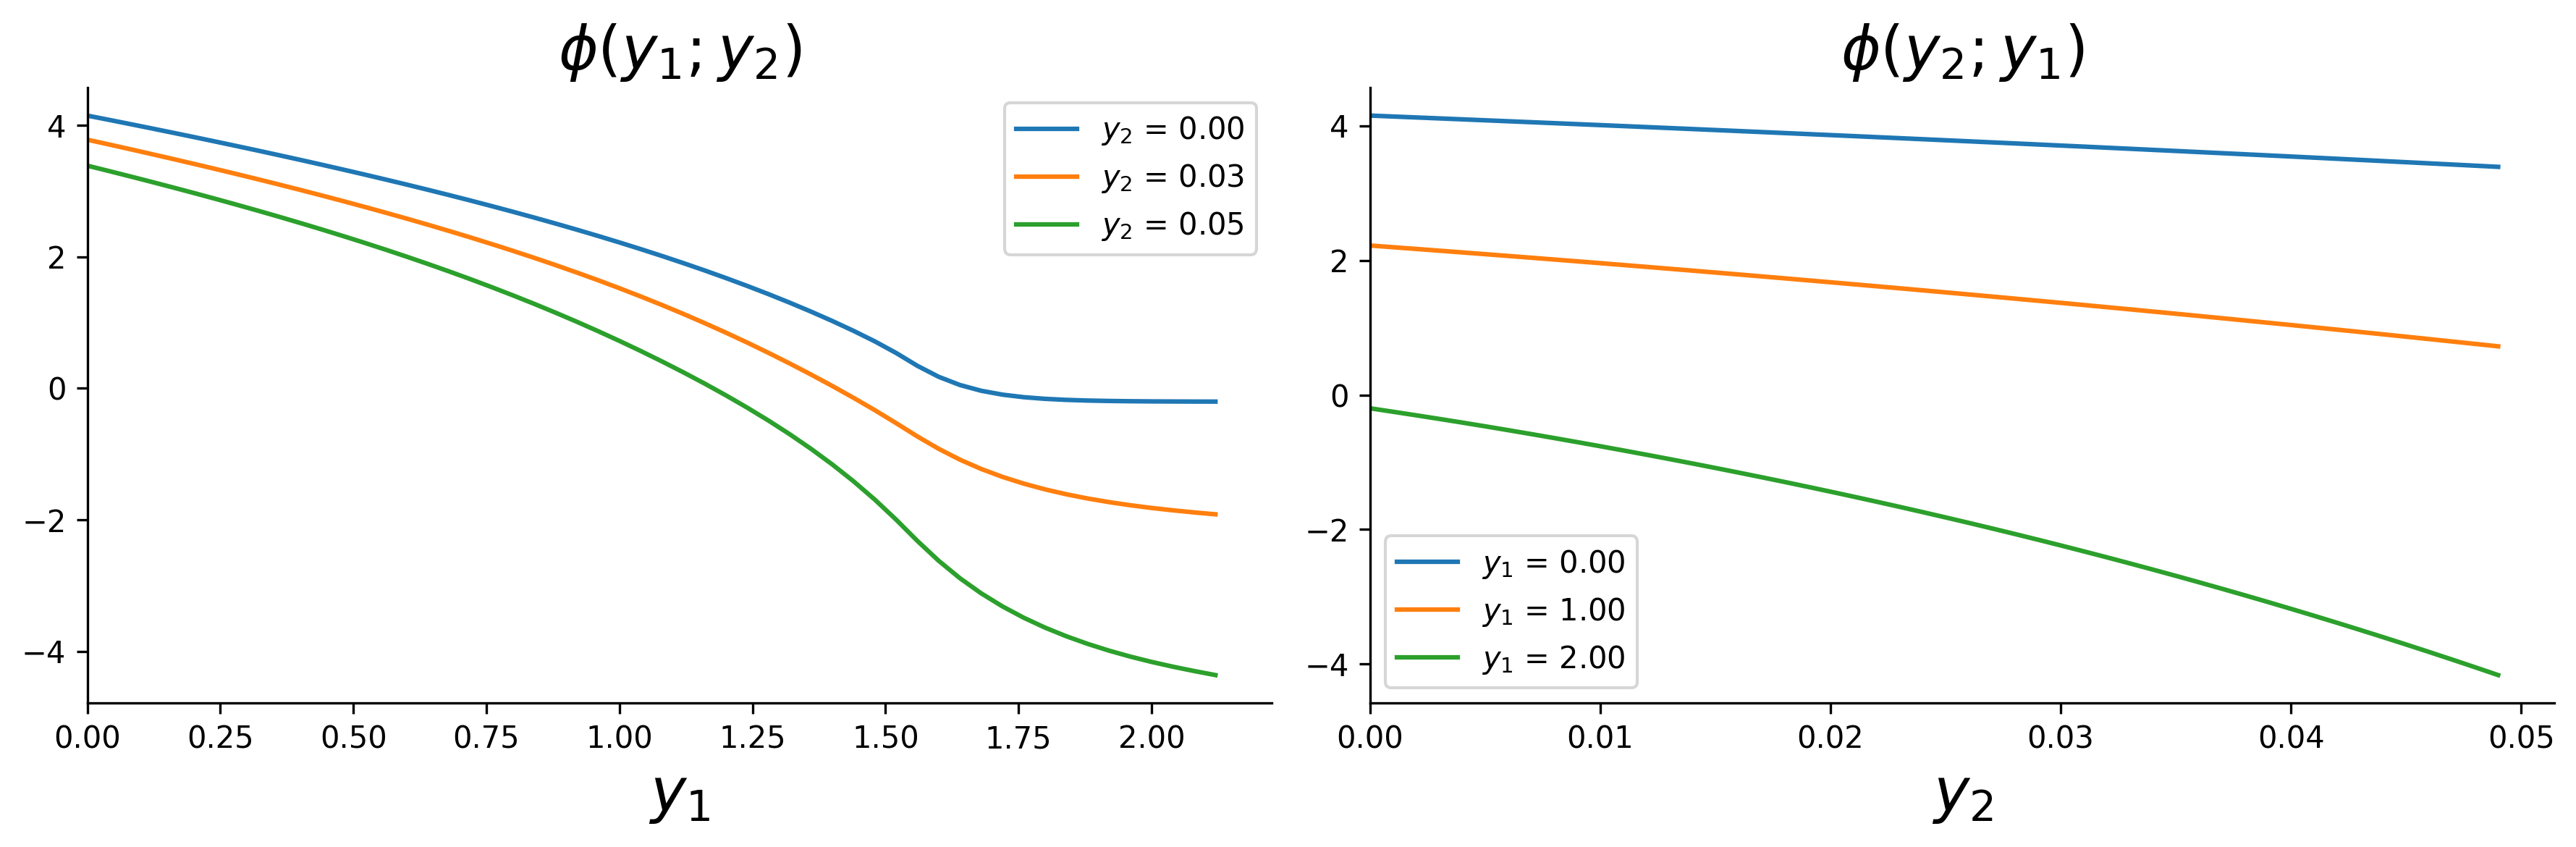

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1 / 4)], v0[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1 / 2)], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
# ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

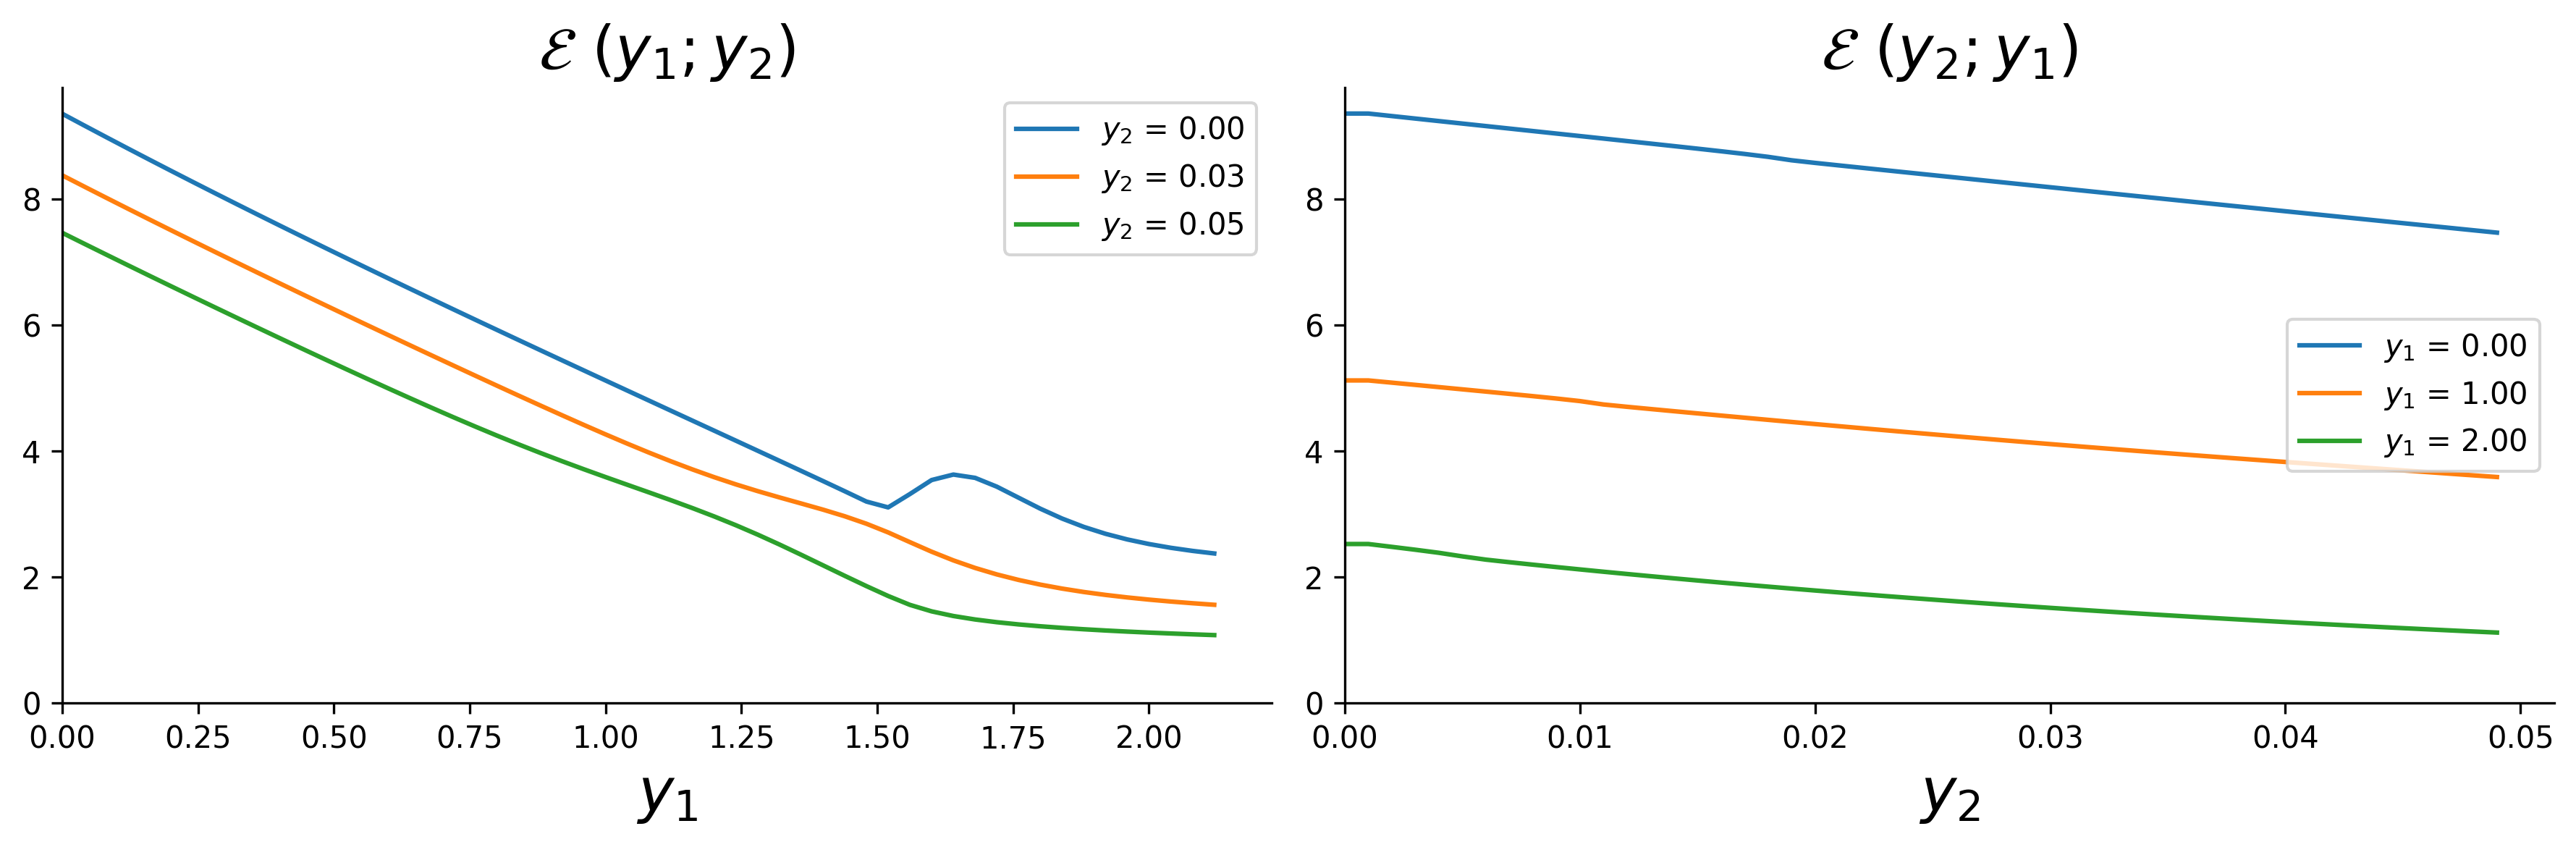

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat_cap[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat_cap[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat_cap[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[int(n_y1/4)], ems[int(n_y1/4)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/4),0]))
ax2.plot(y2_mat[int(n_y1/2)], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")
plt.show()

In [47]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [48]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = y2_0 - λ*y2_0 + λ*θ*Et[i] 
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [49]:
et_list_compare = list()
for γ3 in γ3_list:
    Et, Y1t,Y2t,  = simulation(y1_grid, y2_grid, solu[γ3]["ems"], λ, θ=np.mean(θ_list), y2_0=np.mean(θ_list))
    et_list_compare.append(Et)

In [50]:
et_prejump, y1t_prejump, y2t_prejump = simulation(y1_grid_cap,
                                                  y2_grid,
                                                  ems,
                                                  λ,
                                                  θ=np.mean(θ_list),
                                                  y1_0 = 1.1,
                                                  y2_0=np.mean(θ_list),
                                                  T=150
                                                 )

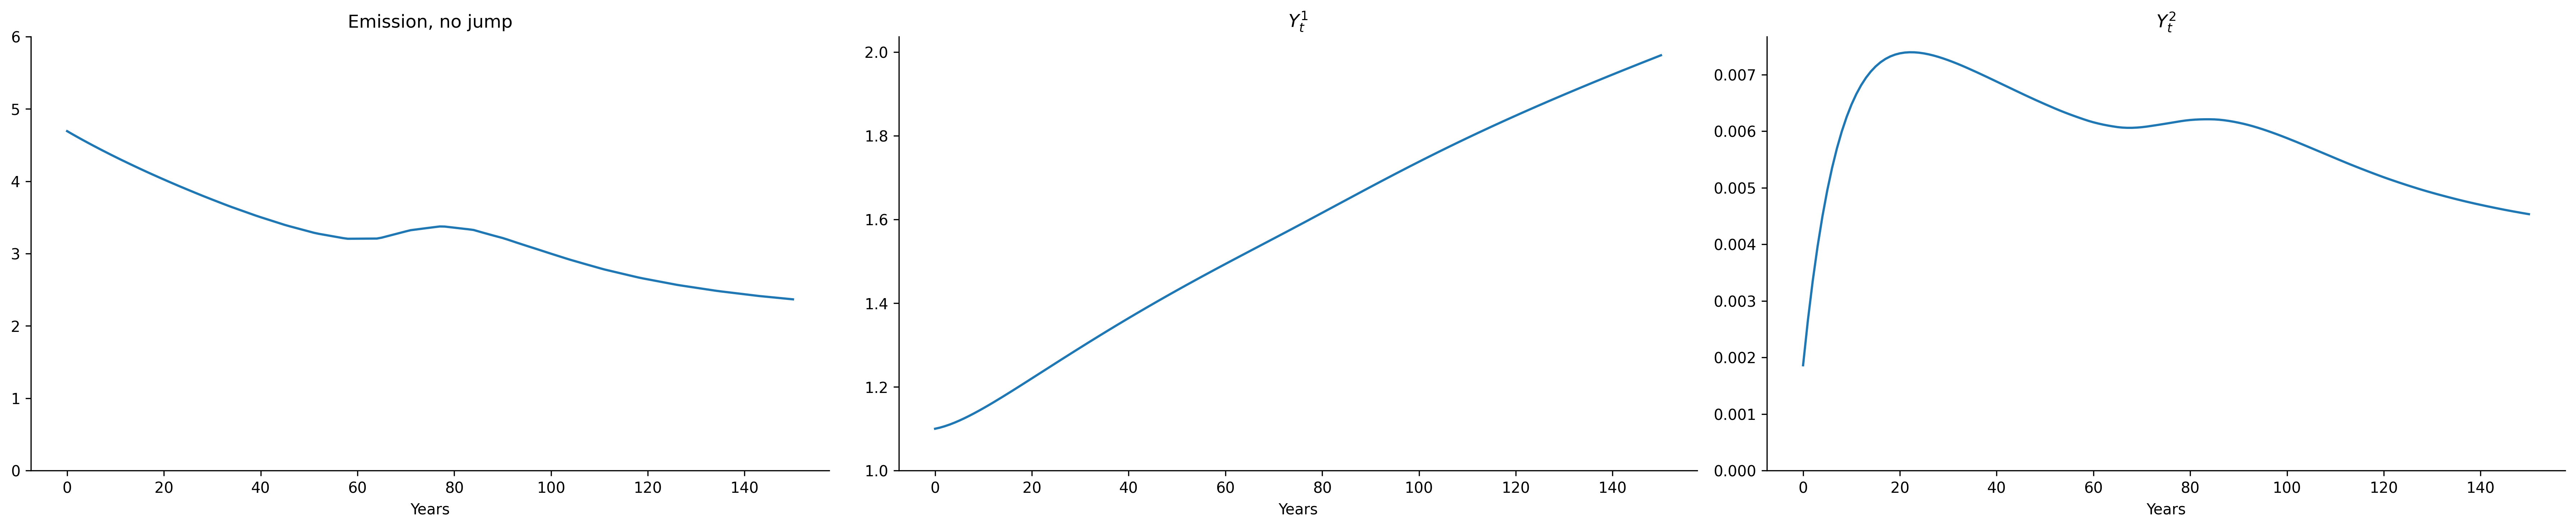

In [54]:
plt.figure(figsize=(24, 5))
plt.subplot(131)
plt.title("Emission, no jump")
plt.plot(et_prejump)
plt.ylim(0,6)
plt.xlabel("Years")
plt.subplot(132)
plt.xlabel("Years")
plt.title(r"$Y_t^1$")
plt.plot(y1t_prejump)
plt.ylim(1)
plt.subplot(133)
plt.title(r"$Y_t^2$")
plt.plot(y2t_prejump)
plt.ylim(0)
plt.xlabel("Years")
plt.tight_layout()
# plt.savefig("e_y1_y2")
plt.show()

In [141]:
Y1t_jump,Y2t_jump, Et_jump = simualte_ems(y1_grid[:numy_bar+1], y2_grid, ems,  dt=1,  T=200)

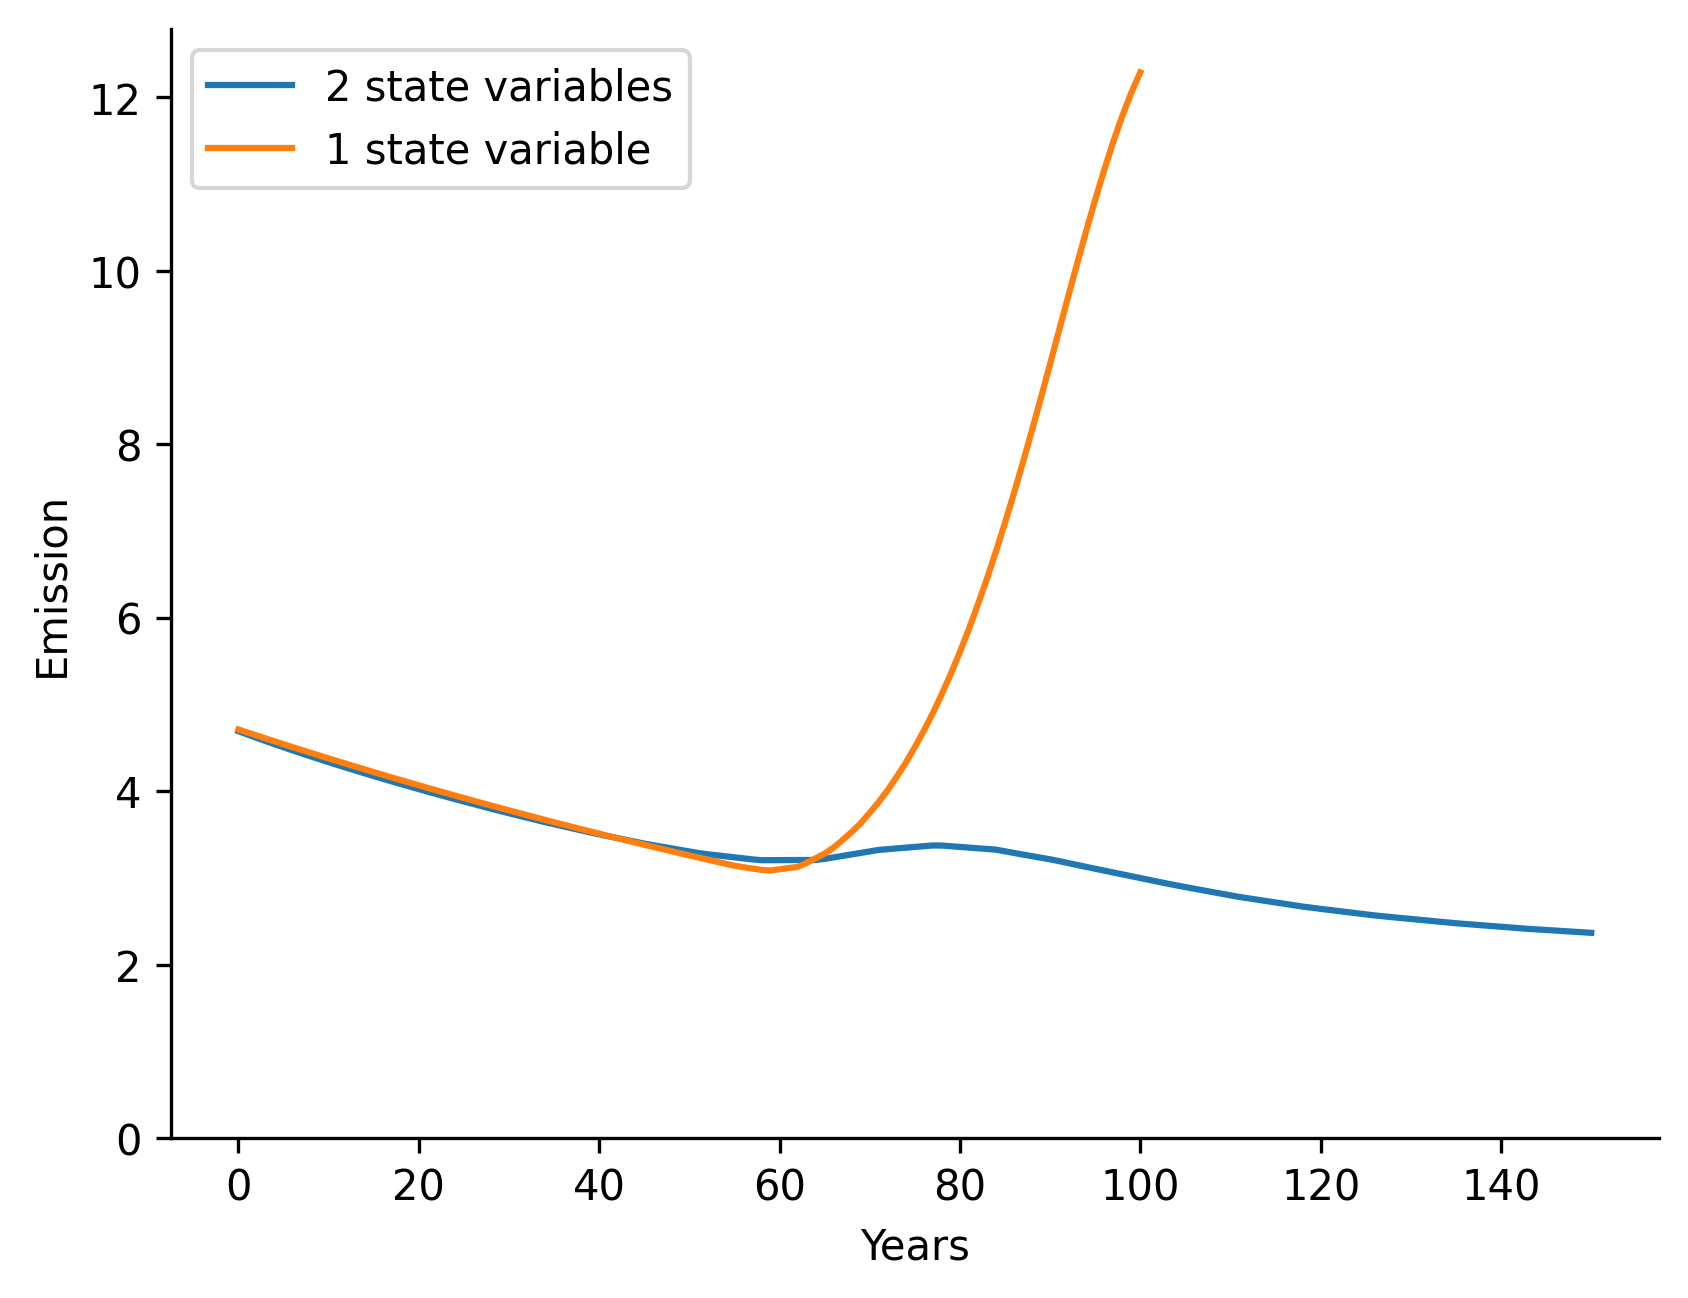

In [64]:
et_1state = np.load("et_1state.npy")
plt.plot(et_prejump, label="2 state variables")
plt.plot(et_1state, label="1 state variable")
plt.ylim(0)
plt.legend()
plt.xlabel("Years")
plt.ylabel("Emission")
# plt.savefig("emissions")
plt.show()

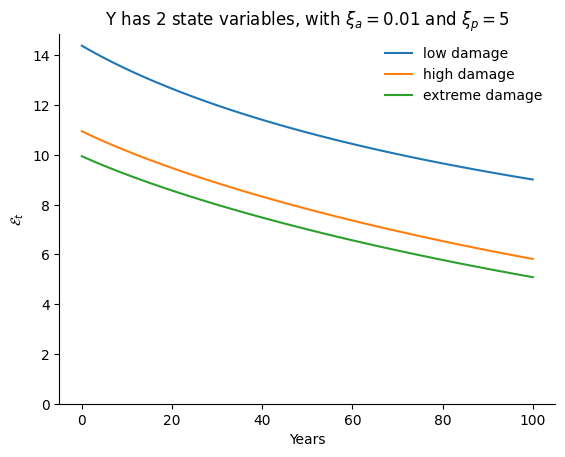

In [115]:
# years = np.arange(0, 100)
colors = ["C0", "C1", "C2"]
for et, dmg, color in zip(et_list_compare, ["low", "high", "extreme"], colors):
    plt.plot(et, label=dmg + " damage", color=color)
plt.legend(frameon=False)
plt.title("Y has 2 state variables, with $\\xi_a = 0.01$ and $\\xi_p = 5$")
plt.xlabel("Years")
plt.ylabel("$\mathcal{E}_t$")
plt.ylim(0)
# plt.savefig("./paper_plots/2state_ems.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

In [118]:
et_list_compare[0]

array([14.38605036, 14.28160059, 14.17961693, 14.07993905, 13.9828976 ,
       13.88777439, 13.79439869, 13.7034387 , 13.61393116, 13.52632205,
       13.44030265, 13.35586425, 13.27297314, 13.19152704, 13.1114756 ,
       13.0328467 , 12.95539226, 12.87942689, 12.8043492 , 12.73089253,
       12.65823903, 12.58697056, 12.51664524, 12.44738401, 12.3792605 ,
       12.31188754, 12.24584623, 12.18043927, 12.11618519, 12.05270434,
       11.99009401, 11.92845294, 11.86742081, 11.80753608, 11.74815154,
       11.68979601, 11.6320357 , 11.57508081, 11.51887665, 11.46329036,
       11.40860085, 11.35430862, 11.30098607, 11.24802197, 11.19595701,
       11.14430941, 11.09341604, 11.0430308 , 10.99329154, 10.9441429 ,
       10.89554822, 10.8476043 , 10.80004071, 10.75314249, 10.70661635,
       10.66077054, 10.61523835, 10.57040794, 10.52585315, 10.48202327,
       10.4384431 , 10.39559573, 10.35297789, 10.31100416, 10.26922609,
       10.22809727, 10.18717386, 10.14685869, 10.10676126, 10.06

In [119]:
years = np.arange(0,100, 1/4)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,12))
ax1.plot(years, Et)
# ax1.plot(y1_mat[:,0], ems[:,49], label="$y_2$ = {:.2f}".format(y2_mat[0,49]))
# ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}_t$', size=20)
ax1.set_xlabel("Years", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
# ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(years, Y1t, label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.set_title('$Y^1_t$', size=20)
ax2.set_xlabel('Years', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
# ax2.legend()
# ax2.set_ylim(0,12)

ax3.plot(years, Y2t)
ax3.set_title('$Y_t^2$', size=20)
ax3.set_xlabel('Years', size=20)
ax3.set_ylim(0)
ax3.set_xlim(0)
fig.tight_layout()
# plt.savefig("simulation.png", bbox_inches="tight", facecolor="w", edgecolor="w")

ValueError: x and y must have same first dimension, but have shapes (400,) and (101,)

In [ ]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [ ]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [ ]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, dt=1/4)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/Et*1000

In [ ]:
plt.plot(years, scc)

In [168]:
# ξₘ is 1000, no ambiguity over damage
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)
ς = 0.1
ξa = 1/100
ξw = 1000
ξp = 5
σy = 1e-5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_1, et_1 = simulate_ems_1d(y_grid[:numy_bar+1], solu["ems"], dt=1/4)

episode: 5000,	 ode error: 9.905671455526233e-05,	 ft error: 3.316203585068678e-05
episode: 5000,	 ode error: 0.0004189112227439215,	 ft error: 2.3994517419301253e-05
episode: 812,	 ode error: 0.0020503496427756313,	 ft error: 9.875385842406104e-09
episode: 5000,	 ode error: 0.0015449065580850421,	 ft error: 1.7729717254388877e-05


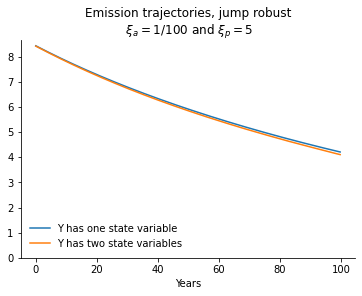

In [402]:
plt.plot(years, et_1, label="Y has one state variable")
plt.plot(years, Et_jump, label="Y has two state variables")
plt.ylim(0)
plt.xlabel("Years")
plt.title("Emission trajectories, jump robust\n $ξ_a = 1/100$ and $ξ_p = 5$")
plt.legend(frameon=False, loc=3)
# plt.savefig("./paper_plots/ems_12compare.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")

In [167]:
def simulate_ems_1d(y1_grid, ems_1d, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
#     Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp1d(y1_grid, ems_1d,)
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y1)
        ems_t[t] = ems_point
        Y1t[t] = y1
#         Y2t[t] = y2
        y1 += ems_point*θ*dt
#         y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, ems_t

In [ ]:
y1_1d, et_1d = simualte_ems_1d(y1_grid, ems_1d, dt=1/4)

In [ ]:
plt.plot(years, et_1d)
plt.plot(years, Et)
plt.xlim(0)
plt.ylim(0, 20)

In [ ]:
scc_1d =  η*(α - invkap)*np.exp(Kt)/(1-η)/et_1d*1000
plt.plot(years, scc_1d, label="pde")
plt.plot(years, scc, label="ode")
plt.legend()